In [29]:


import datetime as datetime
import json
import os

from IPython.display import HTML
import datarobot as dr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import shapely.geometry
import shapely.wkt
import yaml

%matplotlib inline

In [30]:

def data_prep_sample(sample_df):
    sample_df["Schedule Date"] = pd.to_datetime(sample_df["Schedule Date"])
    sample_df["Appointment Date"] = pd.to_datetime(sample_df["Appointment Date"])

    # calulate the schedule delta between scheduled day and appointment day. Empty out the time so we are just left with days
    sample_df["Appointment/Schedule Delta"] = (
        sample_df["Appointment Date"]
        - sample_df["Schedule Date"].apply(
            lambda t: t.replace(minute=0, hour=0, second=0, microsecond=0)
        )
    ).apply(lambda t: t.days)

    # Calculate a new column that is the distance between the neighborhood and the clinic
    sample_df["Distance"] = df.apply(
        lambda l: calcDistance(l["Neighborhood"], l["Clinic Location"]), axis=1
    )

    sample_df["Appointment Date"] = sample_df["Appointment Date"].apply(
        lambda l: str(l)
    )
    sample_df["Schedule Date"] = sample_df["Schedule Date"].apply(lambda l: str(l))

    return sample_df

In [31]:
df = pd.read_csv('no_show.csv')
df.info()
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   no_show              80000 non-null  bool  
 1   Patient ID           80000 non-null  object
 2   Appointment ID       80000 non-null  object
 3   Gender               80000 non-null  object
 4   Age                  80000 non-null  int64 
 5   Alcohol Consumption  80000 non-null  object
 6   Hypertension         80000 non-null  bool  
 7   Diabetes             80000 non-null  bool  
 8   Appointment Date     80000 non-null  object
 9   Schedule Date        80000 non-null  object
 10  Appointment Reason   80000 non-null  object
 11  Clinic Location      80000 non-null  object
 12  Specialty            80000 non-null  object
 13  Neighborhood         80000 non-null  object
dtypes: bool(3), int64(1), object(10)
memory usage: 6.9+ MB


,no_show,Patient ID,Appointment ID,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood
0,False,649e3901-e56b-41d9-b2d3-f61ce708a415,659a5257-c2f0-4eda-a2bb-ebc4bd9ce4e4,F,43,5/week,False,False,2021-01-14T10:30:00,2020-10-26T00:00:00,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill
1,False,3028fd02-a20a-4233-ac16-b571dde4540c,7ae6e7f8-3788-48d2-9fbc-11114ec28bfe,F,37,0/week,False,True,2021-02-17T14:00:00,2021-01-25T00:00:00,OFFICE/OUTPATIENT VISIT EST,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View


no_show:
no_show
False    0.959825
True     0.040175
Name: proportion, dtype: float64

Number of Clinic Locations: 9

Number of Neighborhoods: 37

Patient ID:


<Axes: ylabel='Frequency'>

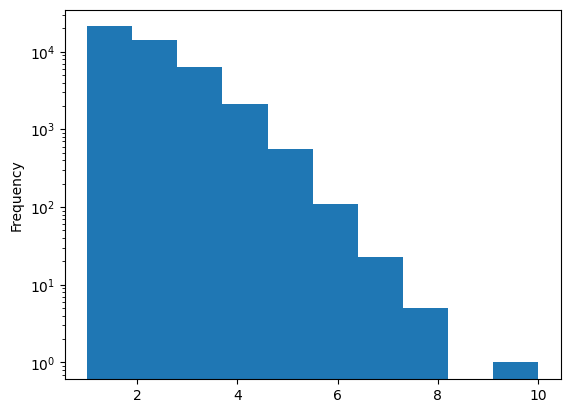

In [32]:
print("no_show:")
print(df["no_show"].value_counts(normalize=True))

# Look at the number of clinic locations
print()
print("Number of Clinic Locations: " + str(df["Clinic Location"].nunique()))

# Examine the number of neighborhoods the patients live in
print()
print("Number of Neighborhoods: " + str(df["Neighborhood"].nunique()))

# Plot the number of appointments per patient
# Notice that most appointments are from patients that are new or have few historical appointments
print()
print("Patient ID:")
df["Patient ID"].value_counts().plot(kind="hist", logy=True)

In [33]:
df["Schedule Date"] = pd.to_datetime(df["Schedule Date"])
df["Appointment Date"] = pd.to_datetime(df["Appointment Date"])

# Calulate the schedule delta between the scheduled day and the appointment day
# Empty out the time so you are just left with days
df["Appointment/Schedule Delta"] = (
    df["Appointment Date"]
    - df["Schedule Date"].apply(
        lambda t: t.replace(minute=0, hour=0, second=0, microsecond=0)
    )
).apply(lambda t: t.days)

In [34]:
geo_df = pd.read_csv('planning_neighborhoods.csv')
geo_df = geo_df.reset_index()
geo = {}

for index, row in geo_df.iterrows():
    geo[row["neighborho"]] = row["the_geom"]

# Create a map of clinic locations using the latitude and longitude of the clinic
clinic_df = pd.read_csv(
    "https://s3.amazonaws.com/datarobot_public_datasets/ai_accelerators/no_show/clinics.csv"
)
clinic_df = clinic_df.reset_index()
clinic = {}

for index, row in clinic_df.iterrows():
    clinic[row["name"]] = [row["lat"], row["long"]]

In [35]:
def calcDistance(neigh, loc):
    # Load the geometry (WKT format)
    p = shapely.wkt.loads(geo[neigh])
    lat = clinic[loc][0]
    long = clinic[loc][1]
    # Convert the lat/long into a point
    point = shapely.geometry.Point(long, lat)
    # Calculate the distance between the centroid of the neighborhood and the point of the clinic
    return p.distance(point)


# Add a new column that is the distance between the neighborhood and the clinic
df["Distance"] = df.apply(
    lambda l: calcDistance(l["Neighborhood"], l["Clinic Location"]), axis=1
)

In [37]:
# Create a map of patient IDs to historical no show rates
hist_no_show_df = pd.read_csv('no_show.csv')
hist_no_show_df = hist_no_show_df.reset_index()
hist_no_show = {}

for index, row in hist_no_show_df.iterrows():
    hist_no_show[row["Patient ID"]] = row["no_show"]

In [39]:
df["Hist No Show"] = df["Patient ID"].apply(lambda l: hist_no_show.get(l, 0.0))

In [40]:
df = df.drop(columns=["Appointment ID"])

In [41]:
df.info()
pd.set_option("display.max_rows", 5)
display(df.loc[df["no_show"] == False])
display(df.loc[df["no_show"] == True])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   no_show                     80000 non-null  bool          
 1   Patient ID                  80000 non-null  object        
 2   Gender                      80000 non-null  object        
 3   Age                         80000 non-null  int64         
 4   Alcohol Consumption         80000 non-null  object        
 5   Hypertension                80000 non-null  bool          
 6   Diabetes                    80000 non-null  bool          
 7   Appointment Date            80000 non-null  datetime64[ns]
 8   Schedule Date               80000 non-null  datetime64[ns]
 9   Appointment Reason          80000 non-null  object        
 10  Clinic Location             80000 non-null  object        
 11  Specialty                   80000 non-null  object    

,no_show,Patient ID,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood,Appointment/Schedule Delta,Distance,Hist No Show
0,False,649e3901-e56b-41d9-b2d3-f61ce708a415,F,43,5/week,False,False,2021-01-14 10:30:00,2020-10-26,CHIROPRACT MANJ 3-4 REGIONS,Mission Bay,Human Performance Center,Russian Hill,80,0.035496,False
1,False,3028fd02-a20a-4233-ac16-b571dde4540c,F,37,0/week,False,True,2021-02-17 14:00:00,2021-01-25,OFFICE/OUTPATIENT VISIT EST,Mission Bay,"Endocrine, Diabetes & Pregnancy Program",Ocean View,23,0.072859,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79998,False,3570b112-021d-44da-be37-d2f76274ac90,F,41,5/week,False,False,2020-07-06 15:30:00,2020-06-17,ELECTROCARDIOGRAM REPORT,Mission Bay,Antenatal Testing Center,Ocean View,19,0.072859,False
79999,False,d066a33a-f9b8-40e9-9188-704e243202f8,F,36,5/week,False,False,2021-09-08 10:30:00,2021-07-20,"OFFICE/OUTPATIENT VISIT EST,LOCM 300-399mg/ml ...",Laurel Village,Primary Care at Laurel Village,Outer Mission,50,0.051993,False


,no_show,Patient ID,Gender,Age,Alcohol Consumption,Hypertension,Diabetes,Appointment Date,Schedule Date,Appointment Reason,Clinic Location,Specialty,Neighborhood,Appointment/Schedule Delta,Distance,Hist No Show
89,True,bdf1e07e-2e60-44d7-8ccb-0a485a0bdb5b,F,58,5/week,True,False,2021-05-14 15:45:00,2021-02-17,OFFICE/OUTPATIENT VISIT EST,Mount Zion,High-Risk Skin Cancer Clinic,Excelsior,86,0.054118,True
153,True,74152ac2-673f-4a12-9062-e01122d2af0f,M,47,> 14/week,False,False,2021-04-27 11:00:00,2021-02-01,SUBSEQUENT HOSPITAL CARE,Mission Bay,Human Performance Center,Presidio,85,0.061707,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79958,True,f7f896bf-266f-42f0-acb8-9f1844c61cec,F,36,0/week,False,False,2020-10-02 16:00:00,2020-06-15,Chest x-ray 2vw frontal&latl,Parnassus,California Center for Pituitary Disorders,Lakeshore,109,0.028724,True
79961,True,715f74a8-325b-4b39-b28b-7722111abb58,M,56,0/week,False,False,2020-07-28 09:45:00,2020-03-17,"OFFICE/OUTPATIENT VISIT EST,Ferumoxytol non-esrd",Mount Zion,Pain Management Center,Excelsior,133,0.054118,True


In [ ]:
df.to_csv('final_dataset.csv', index=False)
